# Data analysis

## Birth dataset

In [1]:
from data_loader import load_nd_clean
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Dropped 5 entirely Nan columns: ['Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']
     AGE  PARITY  GESTAGE  APGAR1  APGAR5  WEIGHT  HEAD  LENGTH  GENDER  \
0     31       1     39.0       9       9    3205  35.0    48.5       2   
1     34       0     38.7       9       9    3105  33.0    52.0       2   
2     34       0     41.0       7       9    3785  36.0    54.0       1   
3     31       1     41.6       9       9    3210  35.0    50.0       2   
4     43       0     38.3       9       9    3550  36.0    47.0       1   
..   ...     ...      ...     ...     ...     ...   ...     ...     ...   
136   17       0     42.3       9       9    3070  33.5    49.0       1   
137   32       0     37.9       9       9    3205  34.5    52.0       1   
138   20       0     41.4       9       9    3510  35.0    52.0       2   
139   29       1     39.4       8       9    3390  36.0    53.5       1   
140   42       1     41.7       9      10    3635  34.5    52.0    

# Data Loading

In [2]:
df= load_nd_clean('Birth.csv')

Dropped 5 entirely Nan columns: ['Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']


### Analyzing sample of 141 pregrant women

In [3]:
df.head(n=5)

,AGE,PARITY,GESTAGE,APGAR1,APGAR5,WEIGHT,HEAD,LENGTH,GENDER,INDUCT,MECLIQUR,NORMAL_D,FORCEPS,ADMIT_NC
0,31,1,39.0,9,9,3205,35.0,48.5,2,1,0,1,0,0
1,34,0,38.7,9,9,3105,33.0,52.0,2,0,0,1,0,0
2,34,0,41.0,7,9,3785,36.0,54.0,1,0,1,0,1,0
3,31,1,41.6,9,9,3210,35.0,50.0,2,0,0,1,0,0
4,43,0,38.3,9,9,3550,36.0,47.0,1,1,0,0,0,0


#### y seems to be PARITY which is equivalent to the number of kids, we will start data exploration with PARITY AS A target to choose subsequent X's to explain the number of children

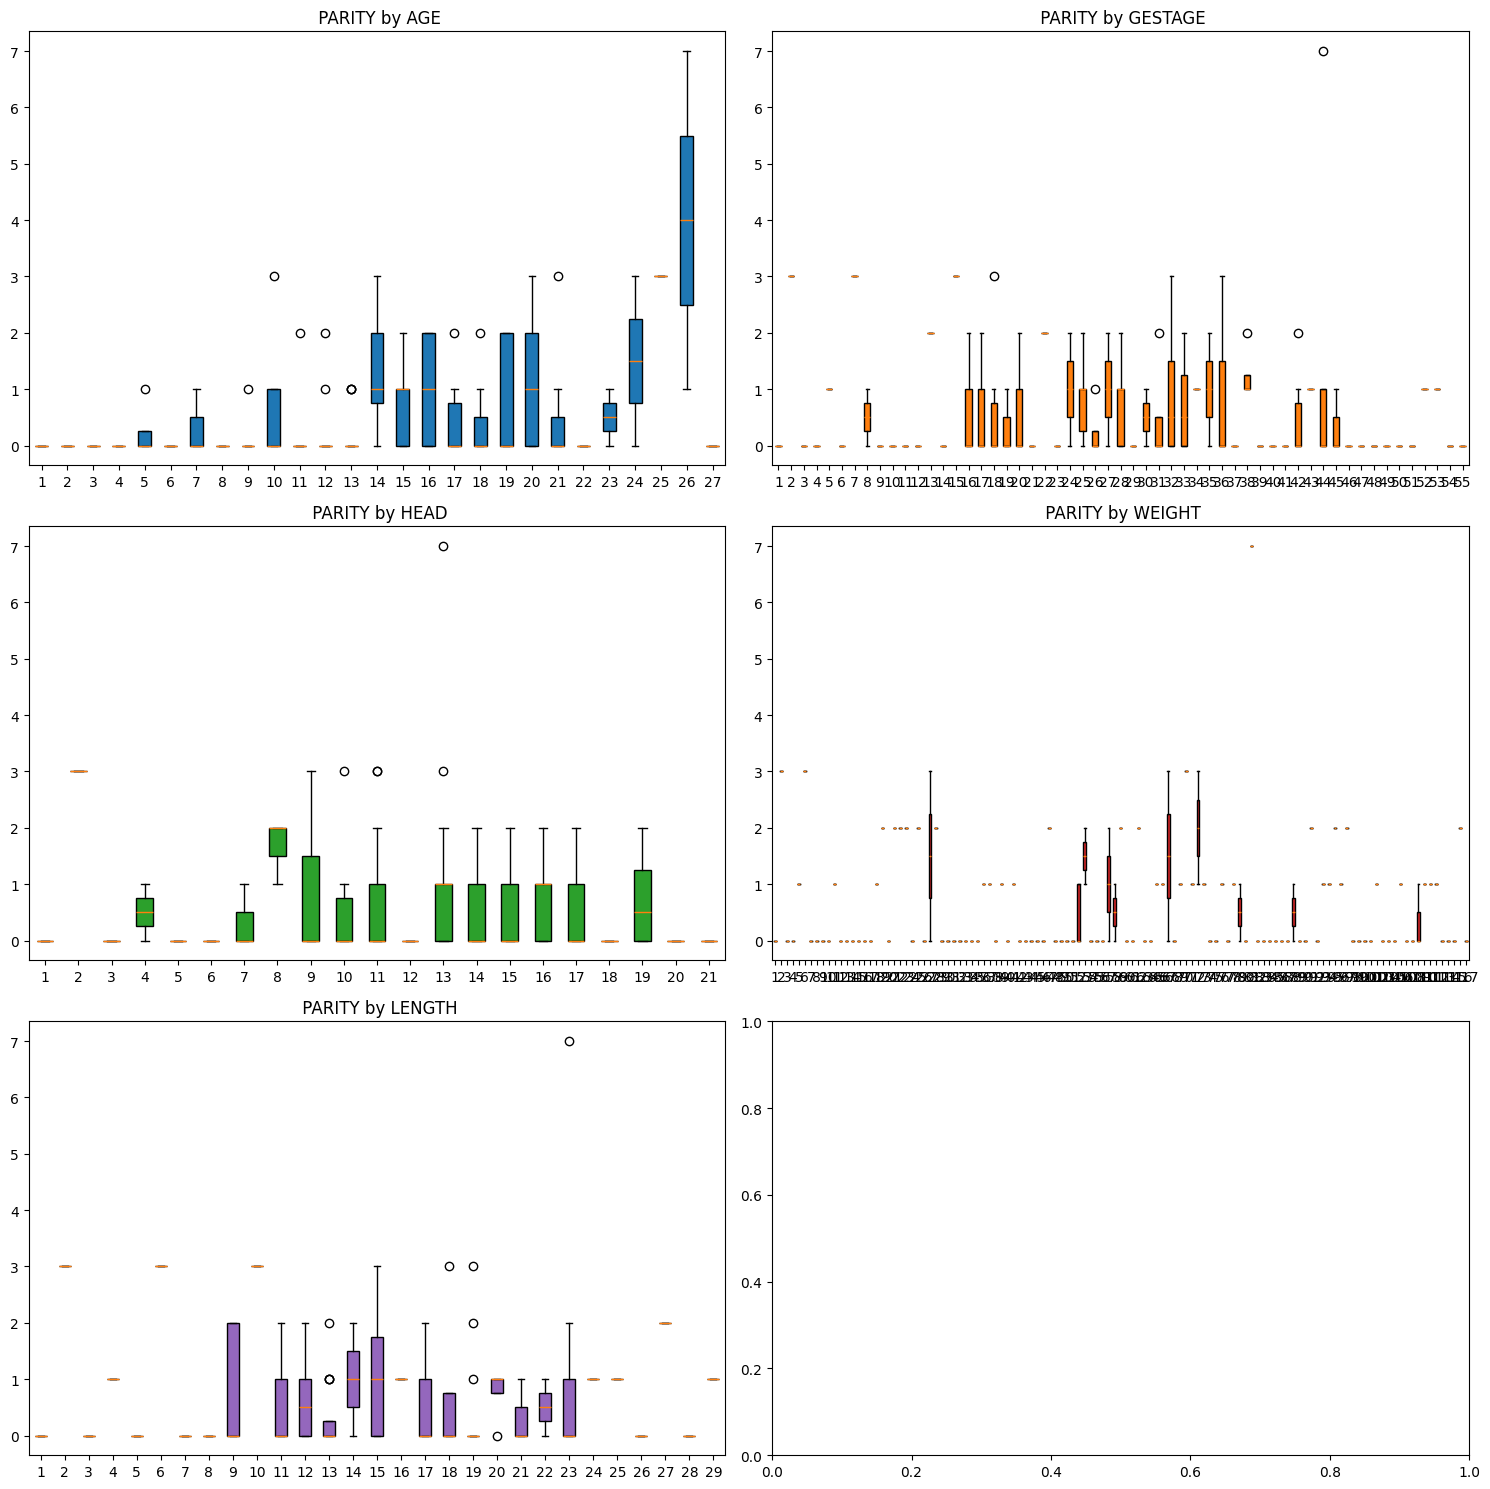

In [4]:
#constinuous X's
cont_xs=['AGE','GESTAGE','HEAD','WEIGHT','LENGTH']
y='PARITY'


#subplots
fig, axes= plt.subplots(3,2,figsize=(15,15))
axes= axes.flatten()

#Iterating through the variables
for i, x in enumerate(cont_xs):
    ax=axes[i]

    #group Data
    data_to_plot=[]
    unique_vals= sorted(df[x].dropna().unique())


    for val in unique_vals:
        y_vals=df[df[x]==val][y].dropna()
        data_to_plot.append(y_vals)

    #boxplot
    bp= ax.boxplot(data_to_plot,
                    patch_artist=True)
    
    #color for the boxes
    for box in bp['boxes']:
        box.set_facecolor(f'C{i}')
    
    ax.set_title(f' {y} by {x}')
    
plt.tight_layout()
plt.show()



### for the poisson Regression we will choose a single X which is the Age which seems to explain the parity better than the other values

In [5]:
X=np.column_stack((np.ones_like(df['AGE']),df['AGE'].values))
y=df[y].values

#### Statmodels results

In [6]:
import statsmodels.api as sm

#Regression with statsmodels
sm_model= sm.GLM(y,X, family= sm.families.Poisson()).fit()
print(sm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  141
Model:                            GLM   Df Residuals:                      139
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -142.99
Date:                Sat, 27 Dec 2025   Deviance:                       165.01
Time:                        10:37:30   Pearson chi2:                     173.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1883
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0895      0.714     -5.730      0.0

### My own implementation

In [7]:
import sys
import os

# Step 1: Add project root to path
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)


In [8]:
from glm import GLM,Poisson,StableGLM

my_model= GLM(y,X,family=Poisson()).fit()
print(my_model.summary())

Generalized Linear Model Regression Results
Model Family:          Poisson
Link Function:         LogLink
Dependent Variable:    y
No. Observations:      141
Model:                 2
Residual:              139
Scale:                 1.187135
Method:                IRLS
Converged:             True
No. Iterations:        5
--------------------------------------------------------------------------------
         coef    std err        z    P>|z|  [0.025  0.975]
x0  -4.08955    0.777569  -5.2594        0  [-5.6136, -2.5655]
x1   0.112945   0.023108   4.8878        0  [0.0677, 0.1582]
--------------------------------------------------------------------------------
Deviance:                  165.0117
Null Deviance:             194.4201
Log-Likelihood:           -142.1899
AIC:                       288.3798
BIC:                       294.2773


## Simulation and Prediction with my model

Predicted mean vs mu difference: 0.000000


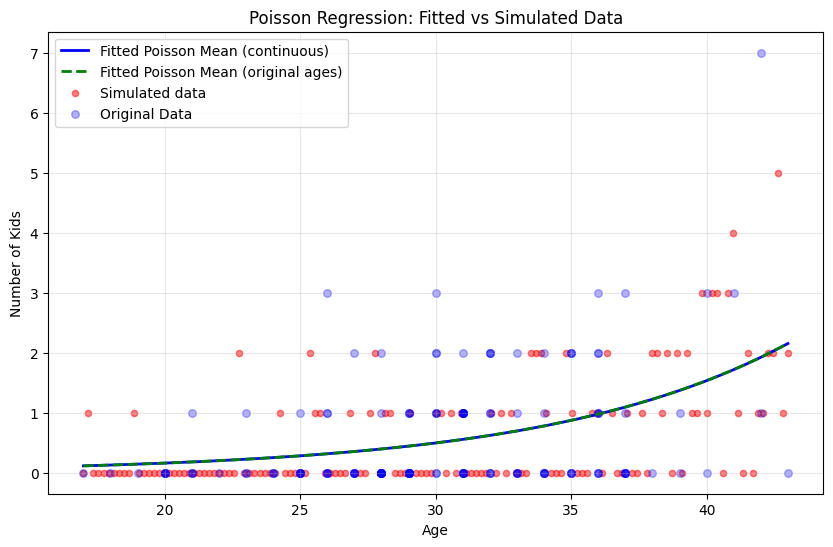

In [9]:
# Extract model parameters
intercept, age_coeff = my_model.params

# Ages simulation - continuous for smooth predictions
ages_cont = np.linspace(X[:, 1].min(), X[:, 1].max(), 141)

# Linear predictor
log_mu = intercept + age_coeff * ages_cont
log_mu_original = intercept + age_coeff * X[:, 1]

# Mu (expected counts)
mu = np.exp(log_mu)
mu_original = np.exp(log_mu_original)

# Simulating Poisson counts
np.random.seed(42)
sim_cnts = np.random.poisson(mu)

# Dataframe for predictions
pred_df = pd.DataFrame({
    'Original_Age': X[:, 1],  # Corrected spelling
    'Mu_original': mu_original,
    'Age': ages_cont,
    'mu': mu,
    'simulated_counts': sim_cnts,
    'log_mu': log_mu,
    'log_mu_original': log_mu_original
})

# Creating design matrix for new values
X_new = np.column_stack((np.ones_like(ages_cont), ages_cont))

# Get predictions from the model
pred_X_new = my_model.predict(exog=X_new)

# Add to dataframe (should match mu since mu = exp(linear predictor))
pred_df['predicted_mean'] = pred_X_new

# Check if they match (they should be very close)
print(f"Predicted mean vs mu difference: {np.max(np.abs(pred_df['predicted_mean'] - pred_df['mu'])):.6f}")

# Plotting
plt.figure(figsize=(10, 6))

# Plot expected counts (fitted line) for continuous ages
plt.plot(pred_df['Age'], 
         pred_df['mu'], 
         'b-', linewidth=2, label='Fitted Poisson Mean (continuous)')

# Plot original data points with mu values
# Note: We need to sort by age for proper line plotting
original_sorted = pred_df[['Original_Age', 'Mu_original']].drop_duplicates()
original_sorted = original_sorted.sort_values('Original_Age')

plt.plot(original_sorted['Original_Age'], 
         original_sorted['Mu_original'], 
         'g--', linewidth=2, label='Fitted Poisson Mean (original ages)')

# Plot simulated counts
plt.scatter(pred_df['Age'], pred_df['simulated_counts'],
            alpha=0.5, color='red', s=20, label='Simulated data')

# Plot original data points
plt.scatter(X[:, 1], y, alpha=0.3, color='blue', s=30, label='Original Data')

plt.xlabel('Age')
plt.ylabel('Number of Kids')
plt.title('Poisson Regression: Fitted vs Simulated Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Death RELATED TO DIABETES ANALYSIS WITH OFFSET IN POISSON REGRESSION

In [16]:
#Dowloading diabetes dataset
df_diabetes= load_nd_clean('diabetes.csv')
age_dummies= pd.get_dummies(df_diabetes['age'],prefix='age',drop_first=False)
age_dummies_ref= age_dummies.drop('age_45-54',axis=1)
age_dummies_ref

,age_25-34,age_35-44,age_55-64,age_65-74,age_75-84,age_85+,age_<25
0,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False
2,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False
5,False,False,False,True,False,False,False
6,False,False,False,False,True,False,False
7,False,False,False,False,False,True,False
8,False,False,False,False,False,False,True
9,True,False,False,False,False,False,False


In [ ]:
#coding gender values into categorical 
df_diabetes['gender_code']= (df_diabetes['gender']=='Female').astype(int)
X_diabetes= pd.concat([
    pd.Series(1,index=df_diabetes.index,name='const'),
    df_diabetes['gender_code'],age_dummies_ref
],axis=1)

age_dummies_ordered = age_dummies_ref[[
    'age_<25', 'age_25-34', 'age_35-44', 
    'age_55-64', 'age_65-74', 'age_75-84', 'age_85+'
]]

X_diabetes = pd.concat([
    pd.Series(1, index=df_diabetes.index, name='const'),
    df_diabetes['gender_code'],
    age_dummies_ordered
], axis=1)


['const', 'gender_code', 'age_<25', 'age_25-34', 'age_35-44', 'age_55-64', 'age_65-74', 'age_75-84', 'age_85+']


### model1: Age + Gender with offset (log population)

In [43]:
my_model2= StableGLM(endog=df_diabetes['deaths'],
                exog=X_diabetes.astype(np.float64),
                family=Poisson(),
                offset=df_diabetes['l_popn']
                )

In [44]:
my_model2.fit()

GLM(family=Poisson, n_obs=16, n_vars=9)

In [45]:
print(my_model2.summary())

Generalized Linear Model Regression Results
Model Family:          Poisson
Link Function:         LogLink
Dependent Variable:    y
No. Observations:      16
Model:                 9
Residual:              7
Scale:                 1.555591
Method:                IRLS
Converged:             True
No. Iterations:        11
--------------------------------------------------------------------------------
         coef    std err         z    P>|z|  [0.025  0.975]
x0  -9.89155    0.210058  -47.0895   0       [-10.3033, -9.4798]
x1  -0.523311   0.081416   -6.4276   0       [-0.6829, -0.3637]
x2  -2.89386    0.595256   -4.8615   0       [-4.0606, -1.7272]
x3  -3.67022    1.26444    -2.9027   0.0037  [-6.1485, -1.1919]
x4  -0.996485   0.383297   -2.5998   0.0093  [-1.7477, -0.2452]
x5   1.23566    0.245572    5.0318   0       [0.7543, 1.7170]
x6   2.33434    0.226435   10.3091   0       [1.8905, 2.7781]
x7   3.41836    0.217948   15.6843   0       [2.9912, 3.8455]
x8   4.30546    0.222347   19.3

In [33]:
sm_model2= sm.GLM(endog=df_diabetes['deaths'],
                 exog= X_diabetes.astype(np.float64),
                family=sm.families.Poisson(),
                offset=df_diabetes['l_popn']
                ).fit()
print(sm_model2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                   16
Model:                            GLM   Df Residuals:                        7
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43.245
Date:                Sat, 27 Dec 2025   Deviance:                       10.889
Time:                        11:17:18   Pearson chi2:                     10.3
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.8915      0.168    -58.732      